<a href="https://colab.research.google.com/github/TonyLiu836/PytorchPractice/blob/main/CSCI5561HW4(PytorchVersion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive


In [35]:

import cv2
import numpy as np
import os
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import math
#import main_functions as main

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from numpy import vstack
from numpy import argmax
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset

'''
class mnistTrainDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self):
        'Initialization'
        im_train = np.loadtxt('mnist_trainfeatures.csv', delimiter=',', dtype=np.float32).T
        print('imtrain.T shape', np.shape(im_train))  #12000x196

        im_train = im_train.reshape((12000,1,14,14))
        self.trainData = torch.from_numpy(im_train)
        self.trainLabels = torch.from_numpy(np.loadtxt('mnist_trainlabels.csv', delimiter=',', dtype=np.int_).T)
        self.n_samples = self.trainData.shape[0]

  def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return self.n_samples
        
  def __getitem__(self, index):
        'Generates one sample of data'
        return self.trainData[index], self.trainLabels[index]

class mnistTestDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self):
        'Initialization'
        im_test = np.loadtxt('mnist_testfeatures.csv', delimiter=',', dtype=np.float32).T
        #print('imtrain.T shape', np.shape(im_train))  #12000x196
        im_test = im_test.reshape((2000,1,14,14))
        self.testData = torch.from_numpy(im_test)
        self.testLabels = torch.from_numpy(np.loadtxt('mnist_testlabels.csv', delimiter=',', dtype=np.int_).T)
        #print(self.testLabels.size())  #2000
        self.n_samples = self.testData.shape[0]
 
  def __len__(self):
        'Denotes the total number of samples'
        #return len(self.list_IDs)
        return self.n_samples
        
  def __getitem__(self, index):
        'Generates one sample of data'
        return self.testData[index], self.testLabels[index]
'''

class mnistDataset(Dataset):
    def __init__(self, samples_file, labels_file):
        self.samples = torch.from_numpy(np.loadtxt("/content/drive/MyDrive/" + samples_file, delimiter=',', dtype=np.float32).T)
        self.samples = self.samples.reshape((self.samples.shape[0],1,14,14)) 
        self.labels = torch.from_numpy(np.loadtxt('/content/drive/MyDrive/' + labels_file, delimiter=',', dtype=np.float32).T)
        self.n_samples = self.samples.shape[0]
    
    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        return self.samples[index], self.labels[index]

def visualize_confusion_matrix(confusion, accuracy, label_classes, name):
    plt.title("{}, accuracy = {:.3f}".format(name, accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()


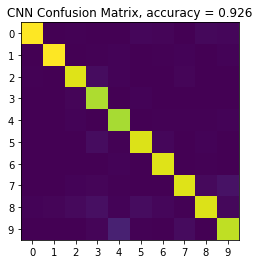

accuracy= 0.926


In [44]:

def evaluateCNNModel(test_dl, model):
    confusion = np.zeros((10, 10))
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        yhat = argmax(yhat, axis=1)
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        predictions.append(yhat)
        actuals.append(actual)
        #print('yhat shape', yhat.shape)  #32x1

        for ind in range(targets.shape[0]):
          #print(ind, yhat[ind], int(targets[ind].item()))
          #confusion[yhat[ind][0], targets[ind]] = confusion[yhat[ind][0], targets[ind]] + 1
          confusion[yhat[ind], int(targets[ind].item())] = confusion[yhat[ind], int(targets[ind].item())] + 1
    predictions, actuals = vstack(predictions), vstack(actuals)

    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    for i in range(10):
        confusion[:,i] = confusion[:,i] / np.sum(confusion[:,i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, acc, label_classes, 'CNN Confusion Matrix')
    return acc

class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv2d(1,3,kernel_size=(3,3), stride=(1,1), padding = (1,1))
      self.pool = nn.MaxPool2d(2,stride=2)
      self.fc = nn.Linear(147,10)
      self.crossEntropyLoss = nn.CrossEntropyLoss()

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = torch.flatten(x,1)
      x = self.fc(x)
      return x 

def trainCNNModel(data, model):
    iters = 500
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.95)
    batch_size = 32
    for iteration in range(iters):
      for i, (inputs, targets) in enumerate(data):
          # clear the gradients
          optimizer.zero_grad()
          # predict outputs
          yhat = model(inputs)
          # calculate loss
          loss = criterion(yhat, targets)
          loss.backward()
          # update weights
          optimizer.step()

    FILE = "CNNmodel.pth"
    torch.save(model, FILE)


def mainCNN():
    batch_size = 32

    #train_data = np.loadtxt('mnist_trainfeatures.csv', delimiter=',', dtype=np.float32).T
    #train_labels = torch.from_numpy(np.loadtxt('mnist_trainlabels.csv', delimiter=',', dtype=np.int_).T)
    #trainDataset = mnistTrainDataset()
    #test_data = np.loadtxt('mnist_testfeatures.csv', delimiter=',', dtype=np.float32).T
    #test_labels = torch.from_numpy(np.loadtxt('mnist_testlabels.csv', delimiter=',', dtype=np.int_).T)
    #testDataset = mnistTestDataset()

    train_data = 'mnist_trainfeatures.csv'
    train_labels = 'mnist_trainlabels.csv'

    
    test_data = 'mnist_testfeatures.csv'
    test_labels = 'mnist_testlabels.csv'

    trainDataset = mnistDataset(train_data, train_labels)
    trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True)
    #model = CNN()
    #trainCNNModel(trainDataloader, model)
    
    
    testDataset = mnistDataset(test_data, test_labels)
    testDataloader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size)
    
    #num_test = testDataset.len()
    #loaded_checkpoint = torch.load("checkpont.pth")
    model = torch.load("CNNmodel.pth")
    acc = evaluateCNNModel(testDataloader, model)
    print("accuracy=",acc)

mainCNN()

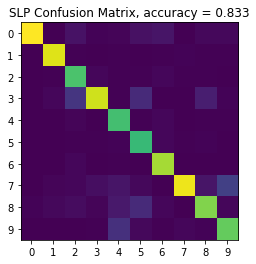

accuracy= 0.833


In [ ]:
def evaluateSLPModel(test_dl, model):
    confusion = np.zeros((10, 10))
    batch_size = 32
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):

        inputs = inputs.reshape((-1, 196))
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        yhat = argmax(yhat, axis=1)
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        predictions.append(yhat)
        actuals.append(actual)
        for ind in range(targets.shape[0]):
            confusion[yhat[ind][0], targets[ind]] = confusion[yhat[ind][0], targets[ind]] + 1
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    for i in range(10):
        confusion[:,i] = confusion[:,i] / np.sum(confusion[:,i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, acc, label_classes, 'SLP Confusion Matrix')
    return acc


input_size = 14*14
class SLP(nn.Module):
  def __init__(self):
    super(SLP, self).__init__()
    self.fc = nn.Linear(input_size, 10)

  def forward(self,x):
    return self.fc(x)

def trainSLPModel(data, model):
  iters = 1000
  lr = 0.001
  batch_size = 32
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = 0.95)
  for iteration in range(iters):
    for i,(inputs, targets) in enumerate(data):
      inputs = inputs.reshape((-1, 196))

      yhat = model(inputs)
      loss = criterion(yhat, targets.long())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  #FILE = "SLPModel.pth"
  torch.save(model,"SLPModel.pth")


def mainSLP():
    batch_size = 32
    trainDataset = mnistTrainDataset()
    trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True)

    model = SLP()
    trainSLPModel(trainDataloader, model)
    
    testDataset = mnistTestDataset()
    testDataloader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size)

    #model = torch.load("SLPModel.pth")
    acc = evaluateSLPModel(testDataloader, model)
    print("accuracy=",acc) 

mainSLP()

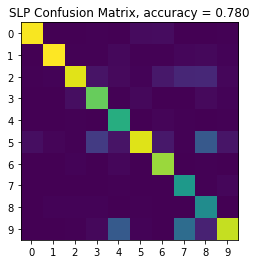

accuracy= 0.78


In [ ]:
def evaluateMLPModel(test_dl, model):
    confusion = np.zeros((10, 10))
    batch_size = 32
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        inputs = inputs.reshape((-1, 196))
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        yhat = argmax(yhat, axis=1)
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        predictions.append(yhat)
        actuals.append(actual)
        for ind in range(targets.shape[0]):
            confusion[yhat[ind][0], targets[ind]] = confusion[yhat[ind][0], targets[ind]] + 1

    predictions, actuals = vstack(predictions), vstack(actuals)

    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    for i in range(10):
        confusion[:,i] = confusion[:,i] / np.sum(confusion[:,i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, acc, label_classes, 'MLP Confusion Matrix')
    return acc


input_size = 14*14
class MLP(nn.Module):
  def __init__(self):
    super(SLP, self).__init__()
    self.fc = nn.Linear(input_size, 10)

  def forward(self, x):
      x = F.relu(self.fc(x))
      #x = torch.flatten(x,1)
      #x = self.fc(x)
      return x 

def trainMLPModel(data, model):
  iters = 2500
  lr = 0.001
  batch_size = 32
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = 0.95)
  for iteration in range(iters):
    for i,(inputs, targets) in enumerate(data):
      inputs = inputs.reshape((-1, 196))
      yhat = model(inputs)
      loss = criterion(yhat, targets.long())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  #FILE = "SLPModel.pth"
  torch.save(model,"MLPModel.pth")


def mainMLP():
    batch_size = 32
    trainDataset = mnistTrainDataset()
    trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, shuffle = True)

    model = SLP()
    trainSLPModel(trainDataloader, model)
    
    testDataset = mnistTestDataset()
    testDataloader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size)
    
    #model = torch.load("MLPModel.pth")
    acc = evaluateSLPModel(testDataloader, model)
    print("accuracy=",acc)  

mainSLP()